In [223]:
# imports
import numpy as np
import matplotlib.pyplot as plt

# tensorflow imports
import tensorflow as tf
from tensorflow import keras

# sklearn imports
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# hide warnings
import warnings
warnings.filterwarnings('ignore')

## Examine the Dataset
Each instance is a 28x28 image of a hand written digit. In total there are 60000 training images and 10000 testing images.

In [269]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [270]:
# Normalize the data
x_train = x_train/255
x_test = x_test/255

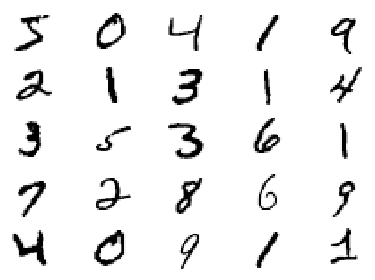

In [271]:
fig, ax_array = plt.subplots(5, 5)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='Greys')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

## Dimensionality reduction with PCA
We can reduce the dimension from 784 to 2 and see some basic cluster when the digits are plotted in this new vector space. In fact, this reduction captures ~93% of the variance in the images.

In [272]:
pca = PCA(n_components=2)

In [273]:
pca_train = pca.fit_transform(x_train.reshape(-1, 28*28))

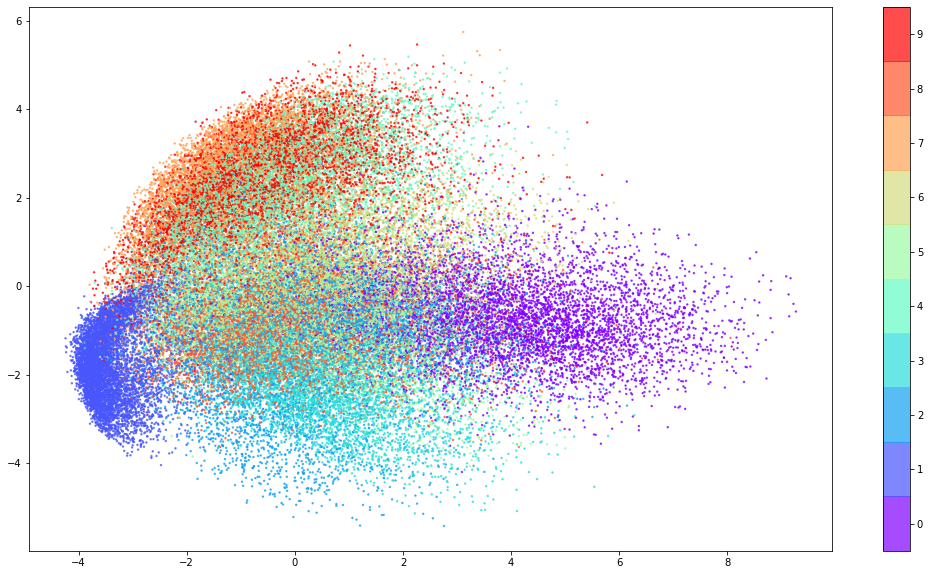

In [274]:
plt.figure(figsize=[18,10])
plt.scatter(pca_train[:,0], pca_train[:,1], c = y_train, cmap='rainbow', s=2, alpha = .7)
cbar = plt.colorbar(boundaries = np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))

In [275]:
1 - pca.explained_variance_ratio_[-1]

0.9290407594274994

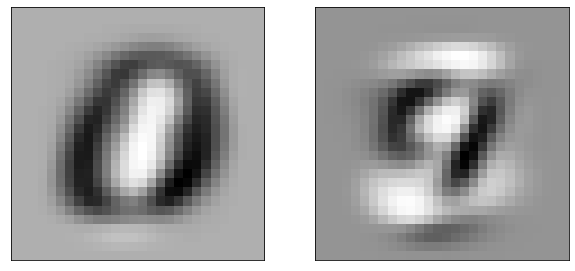

In [276]:
# Plot the two "eigen-digits"
fig, ax_array = plt.subplots(1, 2, figsize=[10, 10])
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(pca.components_[i].reshape(28,28), cmap='Greys')
plt.setp(axes, xticks=[], yticks=[]);

In this new reduced vector space the digits looked blurred out. It turns out that the 7% of the variance lost also captures much of the subtlety of the handwritten digits.

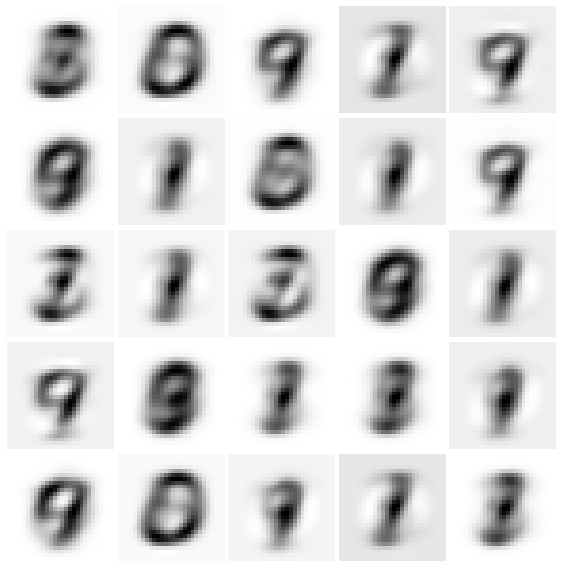

In [277]:
x_train_reduced = pca.inverse_transform(pca_train)

fig, ax_array = plt.subplots(5, 5, figsize=[8, 8])
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(x_train_reduced.reshape(-1,28,28)[i], cmap='Greys')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

Using 25 compponets captures much more of the variance.

In [310]:
big_pca = PCA(n_components=25)

In [311]:
big_pca_train = big_pca.fit_transform(x_train.reshape(-1, 28*28))

In [313]:
# Now we are capturing ~99 percent of the variance.
1 - big_pca.explained_variance_ratio_[-1]

0.9911674122104783

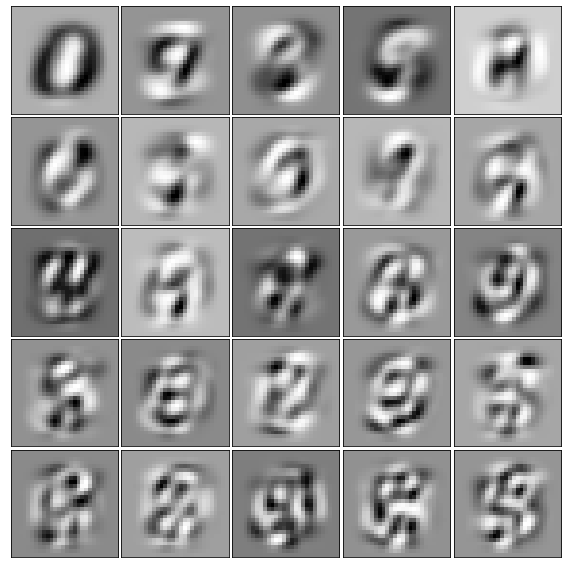

In [314]:
# Here are the first 25 eigenvectors
fig, ax_array = plt.subplots(5, 5, figsize=[8, 8])
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(big_pca.components_[i].reshape(28,28), cmap='Greys')
plt.setp(axes, xticks=[], yticks=[]);
plt.tight_layout(h_pad=0, w_pad=0.01)

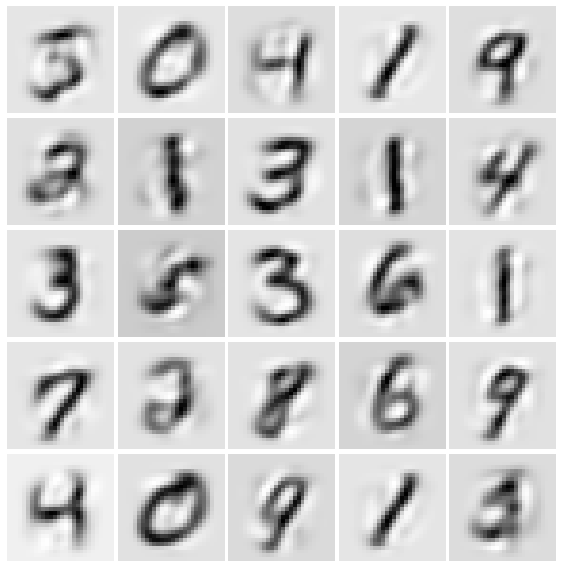

In [315]:
x_train_reduced_big = big_pca.inverse_transform(big_pca_train)

fig, ax_array = plt.subplots(5, 5, figsize=[8, 8])
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(x_train_reduced_10.reshape(-1,28,28)[i], cmap='Greys')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

## Logistic Regression
Now lets test how logistic regression does predicting with the full images, the 2 component pca, and the 25 component pca. 

In [316]:
lr = LogisticRegression()
lr_pca = LogisticRegression()
lr_big_pca = LogisticRegression()

In [317]:
lr.fit(x_train.reshape(-1, 28*28), y_train)
lr_pca.fit(pca_train, y_train)
lr_big_pca.fit(big_pca_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [307]:
# Using all of the information we are able to predict on the test set using 92.55 percent accuracy
lr.score(x_test.reshape(-1, 28*28), y_test)

0.9258

In [308]:
# Reducing the dimensions to two greatly reduces the accuracy.
lr_pca.score(pca.transform(x_test.reshape(-1, 28*28)), y_test)

0.4464

In [318]:
# However keeping 25 component fit is able to preict the results up to almost 90 percent accuray. 
lr_big_pca.score(big_pca.transform(x_test.reshape(-1, 28*28)), y_test)

0.892